# Import the necessary libraries

In [1]:
import torch
import torchvision.datasets as datasets 
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
import os

# Load the CIFAR dataset

In [2]:
# Make torch deterministic
_ = torch.manual_seed(0)

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

# Load the MNIST dataset
fmnist_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# Create a dataloader for the training
train_loader = torch.utils.data.DataLoader(fmnist_trainset, batch_size=10, shuffle=True)

# Load the MNIST test set
fmnist_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(fmnist_testset, batch_size=10, shuffle=True)

100%|██████████| 170M/170M [00:18<00:00, 9.42MB/s] 


In [5]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
#check the size and shape
image, label = next(iter(train_loader))
classes = fmnist_trainset.classes
print(image.shape, label.shape)

torch.Size([10, 3, 32, 32]) torch.Size([10])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5002179..1.8652618].


Text(0.5, 1.0, 'Label: cat')

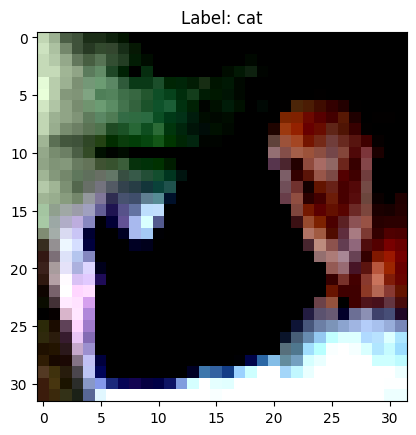

In [8]:
idx = 3
plt.imshow(image[idx].permute(1,2,0), cmap='gray')
plt.title(f'Label: {classes[label[idx].item()]}')

# Define the model

In [9]:
#lets use a pretrained resnet18 model

from torchvision.models import ResNet18_Weights

model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
# Modify the model to fit the FashionMNIST dataset
model.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(512, 10)

In [10]:
net = model
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
#sanity check
image, label = next(iter(train_loader))
output = net(image.to(device))
print(output[3])

tensor([-0.4896, -0.5672, -1.3271, -0.1048,  1.0587, -0.2527, -0.8475,  0.2661,
         1.0041,  1.2994], grad_fn=<SelectBackward0>)


# Train the model

In [13]:
def train(train_loader, net, epochs:int = 5, total_iterations_limit: int = None):
    cross_el = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    total_iterations = 0

    for epoch in range(epochs):
        net.train()

        loss_sum = 0
        num_iterations = 0

        data_iterator = tqdm(train_loader, desc=f'Epoch {epoch+1}')
        if total_iterations_limit is not None:
            data_iterator.total = total_iterations_limit
        for data in data_iterator:
            num_iterations += 1
            total_iterations += 1
            x, y = data
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = net(x)
            loss = cross_el(output, y)
            loss_sum += loss.item()
            avg_loss = loss_sum / num_iterations
            data_iterator.set_postfix(loss=avg_loss)
            loss.backward()
            optimizer.step()

            if total_iterations_limit is not None and total_iterations >= total_iterations_limit:
                return
            
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp_delme.p")
    print('Size (KB):', os.path.getsize("temp_delme.p")/1e3)
    os.remove('temp_delme.p')

MODEL_FILENAME = 'cifar.pt'

if Path(MODEL_FILENAME).exists():
    net.load_state_dict(torch.load(MODEL_FILENAME))
    print('Loaded model from disk')
else:
    train(train_loader, net, epochs=1)
    # Save the model to disk
    torch.save(net.state_dict(), MODEL_FILENAME)

Epoch 1: 100%|██████████| 5000/5000 [16:58<00:00,  4.91it/s, loss=2.05]


# Define the testing loop

In [14]:
def test(model: nn.Module, total_iterations: int = None) -> None:
    correct = 0
    total = 0

    iterations = 0

    model.eval()

    with torch.no_grad():
        for data in tqdm(test_loader, desc='Testing'):
            x, y = data
            x = x.to(device)
            y = y.to(device)
            output = model(x)
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    correct +=1
                total +=1
            iterations += 1
            if total_iterations is not None and iterations >= total_iterations:
                break
    print(f'Accuracy: {round(correct/total, 3)}')

# Print weights and size of the model before quantization

In [15]:
# Print the weights matrix of the model before quantization
print('Weights before quantization')
print(net.conv1.weight[0])
print(net.conv1.weight.dtype)

Weights before quantization
tensor([[[-7.5427e-02,  4.1682e-02,  4.9491e-02,  7.0368e-02,  1.8078e-02,
           3.7474e-02,  7.7130e-02],
         [ 9.1967e-02,  8.8117e-02, -3.1272e-02,  6.8134e-02,  1.2669e-02,
           8.5247e-02,  8.7015e-02],
         [ 1.4388e-01,  1.8098e-01,  7.9465e-02,  1.0141e-01,  1.2517e-01,
           1.8271e-01,  1.2789e-01],
         [-1.3719e-02,  8.2254e-02,  1.2364e-01,  4.9652e-02, -5.0323e-02,
           2.7646e-02,  1.0850e-01],
         [-9.3617e-02,  1.4663e-03,  4.0007e-03,  6.2510e-03, -1.2005e-01,
          -1.4864e-01, -2.2452e-02],
         [-1.4286e-01, -1.1743e-01, -1.9753e-01, -3.6660e-02, -3.1365e-02,
          -1.6140e-01, -1.2696e-01],
         [-2.0908e-02,  1.2107e-02, -1.6775e-01, -5.7777e-03, -9.9790e-02,
          -2.5341e-02, -1.6737e-03]],

        [[-7.9495e-02, -1.1530e-01, -3.3373e-02, -8.8984e-02, -5.1620e-02,
          -1.1861e-01, -8.9330e-02],
         [-2.7335e-02, -8.3369e-02, -6.4884e-02, -1.3379e-01, -1.0908e-01,

In [16]:
print('Size of the model before quantization')
print_size_of_model(net)

Size of the model before quantization
Size (KB): 44804.427


In [17]:
print('Accuracy of the model before quantization: ')
test(net)

Accuracy of the model before quantization: 


Testing: 100%|██████████| 1000/1000 [00:16<00:00, 61.40it/s]

Accuracy: 0.357


# Apply the quantization observers and config

In [18]:
from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx

In [20]:
example_input = torch.randn(1, 1, 28, 28) # dummy input for quantization
torch.backends.quantized.engine = 'fbgemm' # change it for 'fbgemm' if you want to use that backend
qconfig = torch.ao.quantization.get_default_qconfig(torch.backends.quantized.engine) # define the backend configuration
model_prepared = prepare_fx(net, {'': qconfig}, example_input) # prepare the model for quantization
model_prepared.eval()


C:\Users\kagad\AppData\Local\Temp\ipykernel_14800\3638247298.py:4: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_prepared = prepare_fx(net, {'': qconfig}, example_input) # prepare the model for quantization
c:\Users\kagad\quantization\.venv\Lib\site-packages\torch\ao\quantization\quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecat

GraphModule(
  (activation_post_process_0): HistogramObserver(min_val=inf, max_val=-inf)
  (conv1): ConvReLU2d(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU(inplace=True)
  )
  (activation_post_process_1): HistogramObserver(min_val=inf, max_val=-inf)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (activation_post_process_2): HistogramObserver(min_val=inf, max_val=-inf)
  (layer1): Module(
    (0): Module(
      (conv1): ConvReLU2d(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (1): Module(
      (conv1): ConvReLU2d(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1,

In [21]:
# Run a few iterations to calibrate the model
with torch.inference_mode():
    for i, (x, _) in enumerate(train_loader):
        model_prepared(x.to(device))
        if i >= 20:
            break

In [22]:
# Convert the prepared model to a quantized model
model_quantized = convert_fx(model_prepared).eval().to(device)

C:\Users\kagad\AppData\Local\Temp\ipykernel_14800\3654225041.py:2: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_quantized = convert_fx(model_prepared).eval().to(device)


In [23]:
torch.save(model_quantized.state_dict(), "model_quantized.pth")

In [24]:
print(f'Check statistics of the various layers')
model_quantized

Check statistics of the various layers


GraphModule(
  (conv1): QuantizedConvReLU2d(3, 64, kernel_size=(7, 7), stride=(2, 2), scale=0.018478740006685257, zero_point=0, padding=(3, 3))
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Module(
    (0): Module(
      (conv1): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.014592686668038368, zero_point=0, padding=(1, 1))
      (conv2): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.03706875815987587, zero_point=71, padding=(1, 1))
    )
    (1): Module(
      (conv1): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.012502055615186691, zero_point=0, padding=(1, 1))
      (conv2): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.048595819622278214, zero_point=58, padding=(1, 1))
    )
  )
  (layer2): Module(
    (0): Module(
      (conv1): QuantizedConvReLU2d(64, 128, kernel_size=(3, 3), stride=(2, 2), scale=0.018113598227500916, zero_point=0, pad

# Compare the dequantized weights and the original weights

In [25]:
print('Original weights: ')
print(net.conv1.weight)  # Display only a small part of the weights for clarity
print('')
print('Dequantized weights: ')
print(torch.dequantize(model_quantized.conv1.weight()))  # Display only a small part of the dequantized weights for clarity
print('')

Original weights: 
Parameter containing:
tensor([[[[-7.5427e-02,  4.1682e-02,  4.9491e-02,  ...,  1.8078e-02,
            3.7474e-02,  7.7130e-02],
          [ 9.1967e-02,  8.8117e-02, -3.1272e-02,  ...,  1.2669e-02,
            8.5247e-02,  8.7015e-02],
          [ 1.4388e-01,  1.8098e-01,  7.9465e-02,  ...,  1.2517e-01,
            1.8271e-01,  1.2789e-01],
          ...,
          [-9.3617e-02,  1.4663e-03,  4.0007e-03,  ..., -1.2005e-01,
           -1.4864e-01, -2.2452e-02],
          [-1.4286e-01, -1.1743e-01, -1.9753e-01,  ..., -3.1365e-02,
           -1.6140e-01, -1.2696e-01],
          [-2.0908e-02,  1.2107e-02, -1.6775e-01,  ..., -9.9790e-02,
           -2.5341e-02, -1.6737e-03]],

         [[-7.9495e-02, -1.1530e-01, -3.3373e-02,  ..., -5.1620e-02,
           -1.1861e-01, -8.9330e-02],
          [-2.7335e-02, -8.3369e-02, -6.4884e-02,  ..., -1.0908e-01,
           -3.5216e-02, -3.7474e-02],
          [-2.7786e-02, -1.7303e-02, -3.5047e-03,  ...,  7.5501e-02,
           -6.241

# Print size and accuracy of the quantized model

In [26]:
print('Size of the model after quantization')
print_size_of_model(model_quantized)

Size of the model after quantization
Size (KB): 11311.969


In [27]:
print('Testing the model after quantization')
test(model_quantized)

Testing the model after quantization


Testing: 100%|██████████| 1000/1000 [00:05<00:00, 174.75it/s]

Accuracy: 0.286


In [ ]:
MODEL_FILENAME = "model_quantized.pth"

model_quantized.load_state_dict(torch.load(MODEL_FILENAME))
model_quantized.to(device)
model_quantized.eval()

# Export the quantized model to ONNX format

ONNX (Open Neural Network Exchange) is an open standard format for representing machine learning models. Converting PyTorch models to ONNX format enables interoperability across different frameworks and deployment platforms.

In [35]:
# Convert the quantized model to ONNX format
dummy_input = torch.randn(1, 3, 32, 32).to(device)

torch.onnx.export(
    model_quantized,
    dummy_input,
    "model_quantized.onnx",
    export_params=True,
    opset_version=13,  # Changed from 11 to 13 for quantized model support
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'},
                  'output': {0: 'batch_size'}}
)

print("Quantized model exported to ONNX format successfully!")

C:\Users\kagad\AppData\Local\Temp\ipykernel_14800\2785603295.py:4: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


Quantized model exported to ONNX format successfully!


In [36]:
import onnxruntime as ort

# Load the ONNX model
ort_session = ort.InferenceSession("model_quantized.onnx")

print("ONNX model loaded successfully!")
print(f"Input name: {ort_session.get_inputs()[0].name}")
print(f"Input shape: {ort_session.get_inputs()[0].shape}")
print(f"Output name: {ort_session.get_outputs()[0].name}")
print(f"Output shape: {ort_session.get_outputs()[0].shape}")

ONNX model loaded successfully!
Input name: input
Input shape: ['batch_size', 3, 32, 32]
Output name: output
Output shape: ['batch_size', 10]


In [37]:
def test_onnx(ort_session, total_iterations: int = None) -> None:
    correct = 0
    total = 0
    iterations = 0

    for data in tqdm(test_loader, desc='Testing ONNX model'):
        x, y = data
        x_numpy = x.numpy()  # Convert to numpy for ONNX runtime
        
        # Run inference with ONNX runtime
        outputs = ort_session.run(None, {'input': x_numpy})
        output = outputs[0]  # Get the output tensor
        
        # Convert back to torch tensor for easier handling
        output = torch.from_numpy(output)
        
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1
        
        iterations += 1
        if total_iterations is not None and iterations >= total_iterations:
            break
    
    print(f'ONNX Model Accuracy: {round(correct/total, 3)}')

In [39]:
test_onnx(ort_session=ort_session)

Testing ONNX model: 100%|██████████| 1000/1000 [00:04<00:00, 233.80it/s]

ONNX Model Accuracy: 0.285


In [40]:
import time
import numpy as np

def benchmark_pytorch_vs_onnx(pytorch_model, onnx_session, num_iterations=100):
    """
    Compare inference speed between PyTorch model and ONNX runtime
    """
    # Prepare test data
    test_input = torch.randn(1, 3, 32, 32).to(device)
    test_input_numpy = test_input.cpu().numpy()
    
    # Warm up runs
    for _ in range(10):
        with torch.no_grad():
            _ = pytorch_model(test_input)
        _ = onnx_session.run(None, {'input': test_input_numpy})
    
    # Benchmark PyTorch
    pytorch_times = []
    pytorch_model.eval()
    
    for _ in range(num_iterations):
        start_time = time.time()
        with torch.no_grad():
            pytorch_output = pytorch_model(test_input)
        end_time = time.time()
        pytorch_times.append(end_time - start_time)
    
    # Benchmark ONNX
    onnx_times = []
    
    for _ in range(num_iterations):
        start_time = time.time()
        onnx_output = onnx_session.run(None, {'input': test_input_numpy})
        end_time = time.time()
        onnx_times.append(end_time - start_time)
    
    # Calculate statistics
    pytorch_avg = np.mean(pytorch_times) * 1000  # Convert to ms
    pytorch_std = np.std(pytorch_times) * 1000
    onnx_avg = np.mean(onnx_times) * 1000
    onnx_std = np.std(onnx_times) * 1000
    
    # Compare outputs
    pytorch_output_numpy = pytorch_output.cpu().numpy()
    onnx_output_numpy = onnx_output[0]
    
    # Calculate differences
    max_diff = np.max(np.abs(pytorch_output_numpy - onnx_output_numpy))
    mean_diff = np.mean(np.abs(pytorch_output_numpy - onnx_output_numpy))
    
    print("=" * 60)
    print("INFERENCE SPEED COMPARISON")
    print("=" * 60)
    print(f"PyTorch Model:    {pytorch_avg:.2f} ± {pytorch_std:.2f} ms")
    print(f"ONNX Runtime:     {onnx_avg:.2f} ± {onnx_std:.2f} ms")
    print(f"Speedup:          {pytorch_avg/onnx_avg:.2f}x")
    print()
    print("=" * 60)
    print("OUTPUT DIFFERENCE ANALYSIS")
    print("=" * 60)
    print(f"Max absolute difference:  {max_diff:.6f}")
    print(f"Mean absolute difference: {mean_diff:.6f}")
    print(f"Are outputs close?:       {np.allclose(pytorch_output_numpy, onnx_output_numpy, atol=1e-5)}")
    
    return {
        'pytorch_times': pytorch_times,
        'onnx_times': onnx_times,
        'pytorch_avg_ms': pytorch_avg,
        'onnx_avg_ms': onnx_avg,
        'speedup': pytorch_avg/onnx_avg,
        'max_diff': max_diff,
        'mean_diff': mean_diff
    }

# Run the benchmark
results = benchmark_pytorch_vs_onnx(model_quantized, ort_session, num_iterations=100)

INFERENCE SPEED COMPARISON
PyTorch Model:    3.39 ± 3.17 ms
ONNX Runtime:     0.85 ± 0.75 ms
Speedup:          3.97x

OUTPUT DIFFERENCE ANALYSIS
Max absolute difference:  0.000000
Mean absolute difference: 0.000000
Are outputs close?:       True
